# With L1 and L2 Regularization

In [1]:
use_l1_reg = True

# Imports

In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
import urllib

from torchsummary import summary
from tqdm import tqdm

# Data Transforms

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train_dataset = datasets.MNIST('./data',
                              train=True,
                              transform=train_transforms,
                              download=True)

test_dataset = datasets.MNIST('./data',
                              train=False,
                              transform=test_transforms,
                              download=True)

# Dataloader

In [6]:
SEED = 1
torch.manual_seed(SEED)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [7]:
cuda

True

# Data Statistics

In [8]:
# train_data = train_dataset.data
# train_data = train_dataset.transform(train_data.numpy())

# print('Numpy shape ', train_dataset.data.cpu().numpy().shape)
# print('Tensor size ', train_dataset.data.size())
# print('min ', torch.min(train_data))
# print('max ', torch.max(train_data))
# print('mean ', torch.mean(train_data))
# print('std ', torch.std(train_data))
# print('var ', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
# plt.show()

# Model

In [9]:
#dropout_value = 0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 26, rf = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 24, rf = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 24, rf = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) 
        # output_size = 12, rf = 6
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 10, rf = 10
        
        
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),            
            nn.ReLU(),
        ) # output_size = 8, rf = 14
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 6, rf = 20

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 6, rf = 24
        
                
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=(6, 6)),
            # nn.ReLU()
        ) # output_size = 1, rf = 28
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            #nn.ReLU()
        ) # output_size = 1, rf = 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

# Model Parameters

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,304
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
       BatchNorm2d-8            [-1, 8, 24, 24]              16
              ReLU-9            [-1, 8, 24, 24]               0
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

# Training and Testing

In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
l1_crit = nn.L1Loss(size_average=False)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # Predict
        y_pred = model(data)
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        
        if use_l1_reg:
            reg_loss = 0
            for param in model.parameters():
                reg_loss += torch.sum(torch.abs(param))

            factor = 0.0005
            loss += factor * reg_loss
            
        train_losses.append(loss)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))  

/home/gauravp/anaconda3/envs/kerasretina/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01) # l2 regularization
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3812902271747589 Batch_id=468 Accuracy=87.31: 100%|██████████| 469/469 [00:04<00:00, 113.50it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1713, Accuracy: 9652/10000 (96.52%)

EPOCH: 1


Loss=0.2517068684101105 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:04<00:00, 120.89it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1345, Accuracy: 9783/10000 (97.83%)

EPOCH: 2


Loss=0.23439742624759674 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:04<00:00, 112.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1972, Accuracy: 9661/10000 (96.61%)

EPOCH: 3


Loss=0.22354094684123993 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:04<00:00, 112.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1471, Accuracy: 9760/10000 (97.60%)

EPOCH: 4


Loss=0.24315795302391052 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:04<00:00, 113.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2115, Accuracy: 9532/10000 (95.32%)

EPOCH: 5


Loss=0.3240596652030945 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:04<00:00, 113.54it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1259, Accuracy: 9812/10000 (98.12%)

EPOCH: 6


Loss=0.2237485945224762 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:04<00:00, 113.65it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1690, Accuracy: 9708/10000 (97.08%)

EPOCH: 7


Loss=0.2280888557434082 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:04<00:00, 113.89it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2857, Accuracy: 9228/10000 (92.28%)

EPOCH: 8


Loss=0.2187812626361847 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:04<00:00, 112.48it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1104, Accuracy: 9776/10000 (97.76%)

EPOCH: 9


Loss=0.20140647888183594 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:04<00:00, 112.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1533, Accuracy: 9745/10000 (97.45%)

EPOCH: 10


Loss=0.1869623363018036 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:04<00:00, 118.62it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1274, Accuracy: 9777/10000 (97.77%)

EPOCH: 11


Loss=0.25134992599487305 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:04<00:00, 113.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3668, Accuracy: 8887/10000 (88.87%)

EPOCH: 12


Loss=0.25845396518707275 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:04<00:00, 113.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2333, Accuracy: 9446/10000 (94.46%)

EPOCH: 13


Loss=0.17646141350269318 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:04<00:00, 112.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1356, Accuracy: 9714/10000 (97.14%)

EPOCH: 14


Loss=0.23448015749454498 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:04<00:00, 112.89it/s]



Test set: Average loss: 0.1106, Accuracy: 9867/10000 (98.67%)



Text(0.5, 1.0, 'Test Accuracy')

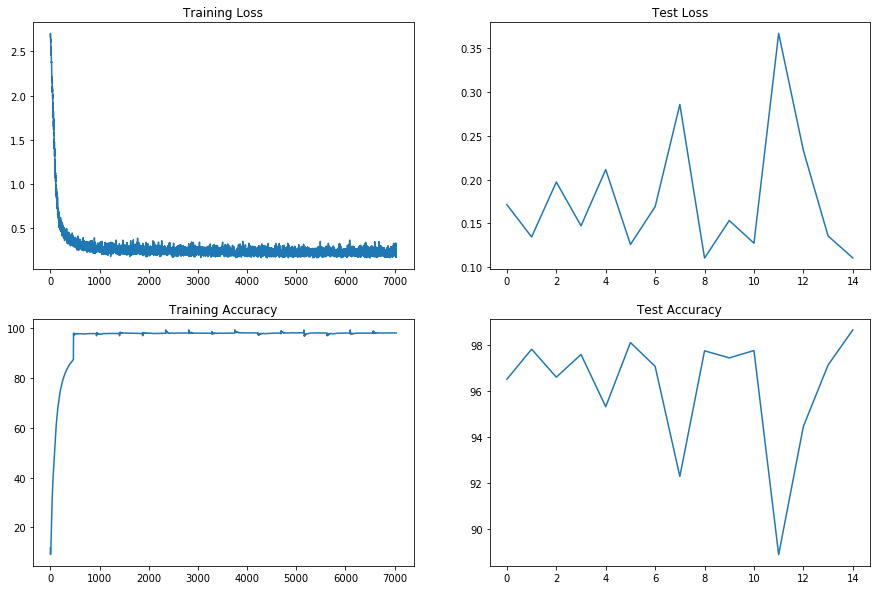

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Result Analysis

- Model Parameters - 13.5k 
- Best train acc -  99.37
- Best test acc -  99.35